# Topic Modeling with LDA
## What are the topics of online Twitter discourse about Ukraine?



Useful links from which I learned how to use Gensim package:  
https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0#:~:text=Topic%20Coherence%20measures%20score%20a,are%20artifacts%20of%20statistical%20inference.

In [1]:
import os
import json
from collections import Counter

In [3]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [4]:
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

In [6]:
import warnings
warnings.filterwarnings('ignore')

/Users/parhomcukmalika/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Topic Modelling: Beginning of March

Getting the corpus

In [ ]:
files3 = os.listdir('results_03_extended')
print(len(files3))

In [19]:
part1 = ['2022-03-02', '2022-03-03', '2022-03-04', '2022-03-07', '2022-03-10', '2022-03-11', '2022-03-12']

In [20]:
import pandas as pd
import re

In [ ]:
def cleanTweet(text):
    corp = [w for w in text.split() if not w.startswith('@') and not w.startswith('https://')]
    return ' '.join(corp)

In [21]:
for_df = []
for f in files3:
    if f.startswith('batch'):
        inF = open(f'results_03_extended/{f}','r')
        data = json.load(inF)
        inF.close()
        for batch in data:
            for tweet in batch['tweets']:
                date = tweet['created_at'].split()[0]
                if date in part1 and tweet['isRetweet'] == False:
                    text = tweet['text'].replace('RT','')
                    text = cleanTweet(text) #remove @_ and https links
                    text = re.sub('[!"$%&\'()*+,-./:;<=>?[\\]^_`{|}~•@]', '', text.lower()) #remove punctuation
                    if len(text.split()) > 5:
                        tweet['cleaned_text'] = text
                        for_df.append(tweet)

In [23]:
df = pd.DataFrame(for_df)
df.drop(columns = ['withheld', 'urls', 'isRetweet', 'public_metrics'], inplace=True)
df

,created_at,id,author_id,text,cleaned_text
0,2022-03-03 03:47:09+00:00,1499229869099597826,352345061,Putin and his oligarch’s children should be re...,putin and his oligarch’s children should be re...
1,2022-03-03 03:47:09+00:00,1499229869221289984,1363948152559185924,Très juste Macron transforme la réalité comme ...,très juste macron transforme la réalité comme ...
2,2022-03-03 03:47:09+00:00,1499229869456117761,1198376932334809089,"Volodymyr Zelensky, the president of Ukraine s...",volodymyr zelensky the president of ukraine si...
3,2022-03-03 03:47:09+00:00,1499229869489672193,1084980649520496642,@GOPChairwoman #GOP the party of donald trump...,#gop the party of donald trump amp his master ...
4,2022-03-03 03:47:09+00:00,1499229869552857093,1401144857419149313,"@MichaelKugelman @SalmanSoz ""Statement"" is onl...",statement is only to appease the west what cou...
...,...,...,...,...,...
237375,2022-03-12 23:53:43+00:00,1502795001956167680,1368654235,@JeremyDBoreing @AdamBaldwin Russia would be a...,russia would be a pushover if they didn’t have...
237376,2022-03-12 23:53:43+00:00,1502795001331425285,1410921956401102850,@marcorubio @KyivIndependent Anyone notice Bid...,anyone notice biden just gave ukraine 300 bill...
237377,2022-03-12 23:53:43+00:00,1502795002593918976,243811680,About 60 child cancer patients from Ukraine bo...,about 60 child cancer patients from ukraine bo...
237378,2022-03-12 23:53:43+00:00,1502795003000758276,1502785523911385091,@h3h3productions Beanie braindead VS Ukrainian...,beanie braindead vs ukrainian chad god i cant ...


In [ ]:
import langid

In [26]:
def isEnglish(clearText):
    lang = langid.classify(clearText)[0]
    if lang=='en':
        return 1
    else:
        return 0

In [27]:
df['is_english'] = df['cleaned_text'].apply(lambda x: isEnglish(x))

#### Preparing the text for modeling

In [103]:
import gensim
from gensim.utils import simple_preprocess

In [31]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

In [35]:
def mapDataWord(row):
    if row['is_english'] == 1:
        return list(sent_to_words([row['cleaned_text']]))
    else:
        return 0

In [36]:
df['data_word'] = df.apply(lambda row: mapDataWord(row), axis=1)

In [38]:
df

,created_at,id,author_id,text,cleaned_text,is_english,data_word
0,2022-03-03 03:47:09+00:00,1499229869099597826,352345061,Putin and his oligarch’s children should be re...,putin and his oligarch’s children should be re...,1,"[[putin, and, his, oligarch, children, should,..."
1,2022-03-03 03:47:09+00:00,1499229869221289984,1363948152559185924,Très juste Macron transforme la réalité comme ...,très juste macron transforme la réalité comme ...,0,0
2,2022-03-03 03:47:09+00:00,1499229869456117761,1198376932334809089,"Volodymyr Zelensky, the president of Ukraine s...",volodymyr zelensky the president of ukraine si...,1,"[[volodymyr, zelensky, the, president, of, ukr..."
3,2022-03-03 03:47:09+00:00,1499229869489672193,1084980649520496642,@GOPChairwoman #GOP the party of donald trump...,#gop the party of donald trump amp his master ...,1,"[[gop, the, party, of, donald, trump, amp, his..."
4,2022-03-03 03:47:09+00:00,1499229869552857093,1401144857419149313,"@MichaelKugelman @SalmanSoz ""Statement"" is onl...",statement is only to appease the west what cou...,1,"[[statement, is, only, to, appease, the, west,..."
...,...,...,...,...,...,...,...
237375,2022-03-12 23:53:43+00:00,1502795001956167680,1368654235,@JeremyDBoreing @AdamBaldwin Russia would be a...,russia would be a pushover if they didn’t have...,1,"[[russia, would, be, pushover, if, they, didn,..."
237376,2022-03-12 23:53:43+00:00,1502795001331425285,1410921956401102850,@marcorubio @KyivIndependent Anyone notice Bid...,anyone notice biden just gave ukraine 300 bill...,1,"[[anyone, notice, biden, just, gave, ukraine, ..."
237377,2022-03-12 23:53:43+00:00,1502795002593918976,243811680,About 60 child cancer patients from Ukraine bo...,about 60 child cancer patients from ukraine bo...,1,"[[about, child, cancer, patients, from, ukrain..."
237378,2022-03-12 23:53:43+00:00,1502795003000758276,1502785523911385091,@h3h3productions Beanie braindead VS Ukrainian...,beanie braindead vs ukrainian chad god i cant ...,1,"[[beanie, braindead, vs, ukrainian, chad, god,..."


In [43]:
datawords = df[df['data_word']!=0]['data_word']

In [45]:
data_words= [i[0] for i in datawords]

In [46]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [47]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        #texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
        texts_out.append([token.lemma_ for token in doc])
    return texts_out

In [48]:
def makeBigrams(row):
    if row['data_word'] != 0:
        return make_bigrams(remove_stopwords(row['data_word']))
    else:
        return 0

In [53]:
df['bigrams'] = df.apply(lambda row: makeBigrams(row), axis=1)

In [55]:
df.drop(columns=['created_at', 'cleaned_text', 'data_word'], inplace=True)

In [58]:
import spacy

In [59]:
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

In [60]:
def lemmatizeRow(row):
    if row['bigrams'] != 0:
        return lemmatization(row['bigrams'])
    else:
        return 0

In [61]:
df['lemmatized'] = df.apply(lambda row: lemmatizeRow(row), axis=1)

In [64]:
df

,id,author_id,text,is_english,bigrams,lemmatized
0,1499229869099597826,352345061,Putin and his oligarch’s children should be re...,1,"[[putin, oligarch, children, removed, fancy, s...","[[putin, oligarch, child, remove, fancy, schoo..."
1,1499229869221289984,1363948152559185924,Très juste Macron transforme la réalité comme ...,0,0,0
2,1499229869456117761,1198376932334809089,"Volodymyr Zelensky, the president of Ukraine s...",1,"[[volodymyr_zelensky, president, ukraine, sinc...","[[volodymyr_zelensky, president, ukraine, sinc..."
3,1499229869489672193,1084980649520496642,@GOPChairwoman #GOP the party of donald trump...,1,"[[gop, party, donald_trump, master, putin, gop...","[[gop, party, donald_trump, master, putin, gop..."
4,1499229869552857093,1401144857419149313,"@MichaelKugelman @SalmanSoz ""Statement"" is onl...",1,"[[statement, appease, west, counts, vote, vote...","[[statement, appease, west, count, vote, vote,..."
...,...,...,...,...,...,...
237375,1502795001956167680,1368654235,@JeremyDBoreing @AdamBaldwin Russia would be a...,1,"[[russia, would, pushover, nukes]]","[[russia, would, pushover, nuke]]"
237376,1502795001331425285,1410921956401102850,@marcorubio @KyivIndependent Anyone notice Bid...,1,"[[anyone, notice, biden, gave, ukraine, billio...","[[anyone, notice, biden, give, ukraine, billio..."
237377,1502795002593918976,243811680,About 60 child cancer patients from Ukraine bo...,1,"[[child, cancer_patients, ukraine, boarded, me...","[[child, cancer_patient, ukraine, board, medic..."
237378,1502795003000758276,1502785523911385091,@h3h3productions Beanie braindead VS Ukrainian...,1,"[[beanie, braindead, vs, ukrainian, chad, god,...","[[beanie, braindead, vs, ukrainian, chad, god,..."


In [ ]:
data_lemmatized = [i[0] for i in df[df['lemmatized']!=0]['lemmatized']]
data_lemmatized[:2]

In [70]:
import gensim.corpora as corpora

In [72]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)
# Create Corpus
texts = data_lemmatized
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1)]]


In [73]:
def getBowRow(row):
    if row['lemmatized'] != 0:
        return id2word.doc2bow(row['lemmatized'][0])
    else:
        return 0

In [74]:
df['bow_format'] = df.apply(lambda row: getBowRow(row), axis=1)

In [89]:
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=15, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)

In [90]:
# Print the Keyword in the 15 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.047*"like" + 0.033*"look" + 0.027*"putin" + 0.023*"news" + 0.020*"russia" '
  '+ 0.017*"see" + 0.015*"guy" + 0.014*"feel" + 0.014*"moscow" + 0.013*"good"'),
 (1,
  '0.066*"nato" + 0.064*"ukraine" + 0.062*"russia" + 0.051*"nuclear" + '
  '0.028*"attack" + 0.027*"country" + 0.025*"invade" + 0.025*"europe" + '
  '0.018*"fire" + 0.016*"power_plant"'),
 (2,
  '0.038*"report" + 0.037*"nazi" + 0.036*"free" + 0.035*"friend" + '
  '0.027*"business" + 0.027*"ukraines" + 0.026*"large" + 0.026*"freedom" + '
  '0.025*"deal" + 0.024*"germany"'),
 (3,
  '0.041*"ukraine" + 0.036*"I" + 0.029*"m" + 0.026*"zelensky" + 0.017*"talk" + '
  '0.016*"video" + 0.015*"ukrainian" + 0.015*"people" + 0.013*"speak" + '
  '0.012*"donate"'),
 (4,
  '0.075*"ukrainian" + 0.052*"ukraine" + 0.032*"refugee" + 0.030*"uk" + '
  '0.026*"russian" + 0.020*"hope" + 0.017*"government" + 0.013*"student" + '
  '0.013*"official" + 0.013*"ask"'),
 (5,
  '0.080*"not" + 0.051*"do" + 0.029*"russia" + 0.028*"putin" + 0.027*"wou

In [ ]:
#import pyLDAvis.gensim
import pickle 
import pyLDAvis

In [106]:
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.191913  0.062083       1        1  11.655365
14    -0.226335  0.019214       2        1   9.100510
11     0.095974  0.150184       3        1   8.430448
1      0.100687  0.105606       4        1   8.417568
6      0.085717  0.140517       5        1   8.118002
12     0.044299  0.082650       6        1   7.628680
7     -0.003989  0.110214       7        1   6.384988
13    -0.226530 -0.095064       8        1   5.880887
0     -0.184922 -0.053753       9        1   5.858347
10     0.193766  0.009038      10        1   5.724200
3     -0.022106 -0.003966      11        1   5.495486
8     -0.051565 -0.026896      12        1   5.107489
9      0.115540 -0.093559      13        1   4.727619
4      0.154627 -0.013427      14        1   4.668887
2      0.116752 -0.392840      15        1   2.801523, topic_info=          Term          Freq         Total Category  logprob  loglift
75         not  22441.000000  22441.000000  Default  30.0000  30.0000
39      russia  67721.000000  67721.000000  Default  29.0000  29.0000
214  ukrainian  22906.000000  22906.000000  Default  28.0000  28.0000
6        putin  60523.000000  60523.000000  Default  27.0000  27.0000
235       nato  16032.000000  16032.000000  Default  26.0000  26.0000
..         ...           ...           ...      ...      ...      ...
916      place    957.217650   1830.257697  Topic15  -4.2538   2.9268
590      check    833.864107   1416.813382  Topic15  -4.3917   3.0449
468     almost    680.507789   1036.728762  Topic15  -4.5950   3.1540
39      russia    904.688483  67721.045569  Topic15  -4.3102  -0.7406
373      still    711.847603   5485.261454  Topic15  -4.5499   1.5331

[825 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
140      11  0.999862           I
768       6  0.998990  absolutely
904       1  0.237725      accept
904      12  0.761274      accept
1142      2  0.999316     account
...     ...       ...         ...
975       9  0.016415    zelensky
975      11  0.982619    zelensky
975      15  0.000566    zelensky
325      11  0.998842   zelenskyy
2253      4  0.997500        zone

[1500 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 15, 12, 2, 7, 13, 8, 14, 1, 11, 4, 9, 10, 5, 3])

In [91]:
def getRowTopic(row):
    if row['bow_format'] != 0:
        topics_list = lda_model.get_document_topics(row['bow_format'])
        topics_list.sort(key=lambda n: n[1], reverse=True)
        topic = topics_list[0][0]
        return topic
    else:
        return 'n/a'

In [92]:
df['topic'] = df.apply(lambda row: getRowTopic(row), axis=1)

In [94]:
save_df = df.drop(columns=['is_english','bigrams','lemmatized','bow_format'])
save_df.to_csv('topic_results_march_part1.csv', index=False)

In [93]:
smaller_df = df.drop(columns=['bigrams','lemmatized','bow_format'])
smaller_df = smaller_df[smaller_df['is_english']==1]
smaller_df

,id,author_id,text,is_english,topic
0,1499229869099597826,352345061,Putin and his oligarch’s children should be re...,1,7
2,1499229869456117761,1198376932334809089,"Volodymyr Zelensky, the president of Ukraine s...",1,6
3,1499229869489672193,1084980649520496642,@GOPChairwoman #GOP the party of donald trump...,1,13
4,1499229869552857093,1401144857419149313,"@MichaelKugelman @SalmanSoz ""Statement"" is onl...",1,9
5,1499229872639692801,1482246518447165441,Florida man blames Putin for why he was speedi...,1,8
...,...,...,...,...,...
237375,1502795001956167680,1368654235,@JeremyDBoreing @AdamBaldwin Russia would be a...,1,1
237376,1502795001331425285,1410921956401102850,@marcorubio @KyivIndependent Anyone notice Bid...,1,8
237377,1502795002593918976,243811680,About 60 child cancer patients from Ukraine bo...,1,1
237378,1502795003000758276,1502785523911385091,@h3h3productions Beanie braindead VS Ukrainian...,1,5


### Exploring the topics

In [199]:
df_topic = smaller_df[smaller_df['topic']==9]
df_topic

,id,author_id,text,is_english,topic
4,1499229869552857093,1401144857419149313,"@MichaelKugelman @SalmanSoz ""Statement"" is onl...",1,9
44,1499229885545418752,1082354683216195584,@CoachRomney @AOShankar2 @KyivIndependent Yes ...,1,9
45,1499229885633490950,1222909979172077570,All Media should immediately stop interviewing...,1,9
89,1499229902926749699,1179998974859792384,"At face value, Russia's act is ""illegal and un...",1,9
109,1499229911487234049,1294482428275429377,Disney Pauses Its Movie Releases in Russia htt...,1,9
...,...,...,...,...,...
237216,1502794931521347588,1347996542658113538,@ggreenwald @IAPonomarenko GTH traitor or even...,1,9
237257,1502794950462906371,958471117982728194,@INArteCarloDoss Seriously thinking of moving ...,1,9
237279,1502794958599770113,165456141,@Snowden what are your thoughts on @Ukraine? #...,1,9
237294,1502794966136877058,1453882755213783040,If he touches one foreign ship it will be on! ...,1,9


In [200]:
import random

explore = random.choices(list(df_topic['id']), k=100)

In [201]:
topic = []
for f in files3:
    if f.startswith('batch'):
        inF = open(f'results_03_extended/{f}','r')
        data = json.load(inF)
        inF.close()
        for batch in data:
            for tweet in batch['tweets']:
                date = tweet['created_at'].split()[0]
                if date in part1 and tweet['isRetweet'] == False:
                    if tweet['id'] in explore:
                        topic.append(tweet['text'])

In [ ]:
topic

### My notes for each topic:

14:
N/A, a lot of mentions of Putin


 "This is Putin's war, not the Russian People's.  If we had a decent President, not even a good one, Putin would be stopped.  I am ashamed my country made this jackass president.",
 'This is why if Putin takes Ukranian cities that will just make the situation worse for him https://t.co/H8jMiOJux6',


13:
Calling out GOP on pro-Putin propaganda, Trump and Putin

 '@WFLA @GovRonDeSantis @USouthFlorida @GovRonDeSantis is just a Putin wantabe #gopKills https://t.co/yFsOLFNpDk',
 'Treasury Sanctions Kremlin Elites, Leaders, Oligarchs, and Family for Enabling Putin’s War Against Ukraine https://t.co/XcwYymOG2A',
 'It’s now got to the point that Johnson is lying as much as Putin. Both are waging a psyops war on their population using lies, mis/disinformation and obfuscation. I’m ashamed that people of this country swallow this shit! What have we become? I’m ashamed to be British. https://t.co/eroS8ygn8L',
 "Evil and more evil. 👠\n\nTrump has been on Putin's side in Ukraine's long struggle against Russian aggression\nhttps://t.co/31U63HcoI3",
 'GOP = Grand Ole Putin Party #UkraineRussiaWar',
 'I fear the GOP has reached a point of disillusionment beyond help. there’s a new branch of right-wing people now in favor of Putin &amp; Russia. ???? We have never trusted Russia. Russian govt is most literally an enemy???? Did you go to history class?? Do u know anything. R u robot',
 '@Surabees @fullsendpodcast Trump made Putin strong again\n#StopPutin #stoptrump #StopPutinNOW \n@GOP #goptheputinparty #GOPtheRussianParty',
'@FoxNews @TuckerCarlson Why are Fox News and Tucker Carlson pushing Putin propaganda? That is the question everybody should be asking.']


12:
N/A

 'Patriot Truth News - Russia Convenes UN Security Council Meeting to Present BioLab Evidence https://t.co/DFJ2Alk0L6',
 'heart wrenching? This comedian president took things as comedy. Misjudged the fact that US is using him as pawn against Russia. His immaturity dragged his country into war. Russia has the capability to end this war in 1 day but treading slow to avoid civilian causality. https://t.co/IzFO4gJ4Lg',
 "@SDonziger While this is important - I think holding Biden responsible for what's going on in Ukraine right now is even more important. We can't let him get away with arming neo-Nazis, training them with the CIA, nation building in Ukraine, &amp; escalating an eight-year-old war with NATO.",




 "Cryptocurrency playing it's part in the #RussianUkrainianWar \n\n- Ukraine is getting crypto donations from  around the world\n- Russia has already increased cryptocurrency reserves including #Bitcoin",


11:
Russian army attacking civillians, children, war crimes

 "@SecBlinken @PowerUSAID @JosepBorrellF @ChrisCoons @NYT, @POTUS While the world's attention is on the war in #ukraine, #eth has continued its Way Crimes with out fear of consequences. Once again another video is showing #eth's soldiers burning Tigreans alive.",
 '@amyklobuchar Thousands of people are killed from Russian bombing in Ukraine. Over 70 children! US should provide #SafeAirliftUkraine and #ProtectUАSky to stop #Putin’s barbaric war on civilians and children.',
 "@GyongyosiMarton @PeterJakab1 @EUCouncil @EUparliament Russia every day bombards our cities and kills innocent civilians including children. Yesterday in Mariupol, rockets hit a maternity hospital and a children's hospital. \nSave our lives by closing the sky over Ukraine!  \nHelp us protect ourselves by providing airplanes!",
 '@SenatorCollins Ukrainians are dying in the cities besieged by Russian troops. Child in #Mariupol died from dehydration (!). We urgently need provide humanitarian airlift to Ukraine as you did in Georgia in 2008 #SafeAirliftUkraine',
 "@lessig @RoKhanna Yesterday the Russians dropped a bomb on a maternity and children's hospital in Mariupol #ukraine, and this is not the first crime against humanity. They killed 70!!!!! children. Please close the sky or give us fighter jets, anti-rocket, anti-aircraft defence #CloseTheSky",
 'The first pkg in the 12 noon GMT bulletin was about a family in Donestk with children injured in "heavy" Ukrainian shelling of civilian areas.',

10:
US buys russian Oil, oil and energy sanctions, (Iran russian ally), oil prices and generally cost of living is getting high US

 '@JoJoFromJerz so is democrats buying oil from russia ...russian collusion????',
 'Abramovich puts Chelsea football club up for sale as clamour for sanctions grows\n\n#chelsea #donations #football #Money #Ukraine #Abramovich #Russia\nhttps://t.co/jnAm6fjo8I',
 '@GooglePlay @TheShineApp Please!! Complete @GooglePlay lock with all apps in Russia. This will stop business and the opportunity to receive services in Russia.\n#StopPutin #StopRussia #GooglePlayExitFromRussia',
 '@SRuhle Rising gas prices are gouging &amp; greed by oil companies! There is NO gas shortage! they pull this bull crap every time something happens that has ZERO to do with our production or imports from countries other than Russia! The media NEVER calls them out on it!',
 '@MajorPoonia Not just Shell. The US government itself is still buying crude oil from Russia. Gazprom is still supplying Europe gas through Ukraine even amid the so-called “invasion” sanctions.',
 'Who fired a missile at the #American Embassy?  Hmmm Iran &amp; Russia are strategic allies form an axis in the Caucasus alongside Armenia. Iran  Russia are also military allies in the conflicts in Syria and Iraq and partners in Afghanistan and post-Soviet Central Asia.',
 '#UnderJoeBiden the USA is buying Russian fuel &amp; Putin is using the profits to finance a war against Ukraine while forcing Americans to pay highest prices ever at pump https://t.co/0rLbcAMsgZ',
 'As businesses isolate Russia, China fills the gap. Given our debt to China, we just strengthened the Eurasian Alliance. Reminder: Trump was trying to end our dependence on China. 2/2',
 '@TheDemocrats @ofirahy @JoeBiden Can you explain how we went from energy independent to begging Russia, Iran, OPEC, and Venezuela for more oil?  I will wait for your thoughtful reply',


 'Yesterday Russia dropped bombs on a maternity hospital in Mariupol.  As a result, 3 people died (including 1 child), 17 were injured. @kocsismate @keplilajos @vigenin @Ilotova @djambazki @rmkanev @peter_agh @tanbacsi You can stop this!  Close the sky over Ukraine! #closethesky https://t.co/H6GYYcrKwH',

9:
Western sanctions, Israel (no sanctions against russia)
https://www.timesofisrael.com/israel-hasnt-joined-anti-russia-sanctions-but-its-firms-need-to-tread-carefully/

 "Since Russia's invasion of Ukraine last week, Western nations have banded together with a series of economic sanctions against Russia, including the banning of Russian banks from SWIFT.",
 '@riley_oleary10\n\n4: URL: https://t.co/J92VCVrbj9\nAs the world overwhelmingly condemns the assault on Ukraine, online opinion in China is mostly pro-Russia, pro-war and pro-Putin.',
'Am I anti Semitic if I criticize Israel for doing this? https://t.co/muzdb0wjGq',
 '@cenkuygur @AnaKasparian I’m disappointed in your narrative of the Russia/Ukraine war. Devoid of meaningful narrative or historical context. Western expansion is a threat to Russia’s national security. Please present some balanced',
 '@TuckerCarlson is a national disgrace and an ongoing national security threat because of his platform for Putin’s propaganda. He’s a fool and Russian tool. #BanPutinPropaganda #StandWithUkraine https://t.co/25v7IEd9Ck',
 '@Reuters Half of the Ukrainian government have Israeli citizenship or relatives that do, so why wouldn’t thry trust daddy Israel?',
 'World Bank halts all programs in Russia, Belarus https://t.co/UeW3tRAiAH https://t.co/aQIaHIs0pv&gt;&gt; #Russia',
 'Google pauses all ad sales in Russia #ArtificialIntelligence #ui via https://t.co/0NnSfBI7JQ https://t.co/QZyd5MuCm7',
 "@AndrewKnight226 China is watching Russia's war closely, as it also wants to colonize Taiwan",
 "Western companies cutting ties to Russia has limited effect, experts say https://t.co/Tv2XAczjWD Karkov/SOPA Images/LightRocket via Getty Images(NEW YORK) -- In light of Russia's unprovoked invasion of Ukraine, many major American and Western companies have decided to drop the...",
 '@ZelenskyyUa @DefenceHQ @BorisJohnson where are you ?Chinese media say you have escaped from kiev.really?',
 'China Says One Of Its Nationals Wounded In Gunfire In Ukraine https://t.co/XfbyfInCPM https://t.co/NdWbiBpGpG',

8:
People hating on Biden for the war and inflation. Trump supporters. If Trump was a president, there would have been no war

'@KremlinRussia_E You know what not one russian leader, especially Putin has ever had? Balls! Putin is hiding in a bunker like a  little girl whining all day. Zelensky -a comedian- has more balls than all russians combined. "I don’t need a ride, I need ammunition” said no Putin or no russian ever!',

'@mdnij34 Because many in the Republican party support Putin.',
'@wbkotv Rep Massey will vote against it. He’s apparently pro-Putin.'
 'Klaus Schwab &amp; Hunter Biden Connected To Ukraine Bio-Labs...\nhttps://t.co/FVyvBB7sLY',
 "@Ericaspeaktruth @Carichampionsoc @Logically_JC and Yet...Putin didn't dare invade Ukraine on Trumps watch but instead chose to do it 100% on Democrats watch.\nRussiaGate logic 🤡🤡🤡",
 '@Michell92668981 No. He was installed and funded by israeli billionaire Ihor Kolomoisky, who also created and funds the neo nazi groups in ukraine.  Zelensky also has more than $1 billion hidden per the Pandora Papers',
 'A LIARS, CORRUPTED. CROOKED AND HIS ADVISORS OBAMA AND HILLARY CLINTON ARE TRYING TO LOOK FOR A WAYS OUT FOR BIDEN, NATO, HARRIS AND THEIRS GOVERNMENT ADMINISTRATION FAILURES.  OURS COUNTRY IS IN AN ECONOMIC CRISIS BECAUSE HE OPEN THE USA 🇺🇸 BORDER TO ILLEGALS IMMIGRANTS.',
 '@JoeBiden Really?! You called the unvaxed unAmerican. You’ve been played, old man, and Putin owns you.',
 '@brianrayguitar Show people just one clip of Fox News support of Putin. Biden is a brainless fake president. No respect around the globe, and being played like a fiddle by Putin.(who has evidence of Hunters corruption)  let’s see your evidence idiot',
 'Trump’s and Putin’s strategy is to convince Trump supporters that Russia wouldn’t have invaded Ukraine if Trump were president. They are going to use that messaging for the midterms and 2024. Putin and Trump need each other politically and Joe Biden is in their way.',
 '@JackPosobiec And they wonder why Putin chose to invade Ukraine now...while Biden is in the WH.',
 '@TheDemocrats Remember… it was Biden’s request to fire the ukraine prosecutor investigating hunters involvement or one billion in aid gets withheld… world war 3 is on Biden',
 '@mail_american I don’t trust Putin but on the other hand why should I trust Ukraine? Zelenskyy is dirty, I know the media &amp; Biden are puffing him up but things just don’t seem up &amp; up. With Biden’s corrupt dealings in Ukraine tells me the 3 day old dead fish isn’t the only thing that stinks!',
 '@ASvidovska @NATO Sorry we have such a coward President in the US if Trump was President None of this would be happening',


 'Zelensky’s “Perfect Phone Call” With Trump in 2019 Explains a Lot Right Now - Slate https://t.co/AVS3tGMTal',
 'That is Democrat Parasites in US Congress! https://t.co/rVrWTAuhcq https://t.co/qYfclZytoz',

7:
Support Ukraine

 '@RonWyden Ukraine needs weapons and humanitarian assistance to defend against #Putin. Stop innocent civilian deaths. @POTUS, provide #SafeAirliftUkraine #StopPutin',
 '@ShibMetaverse 0x573D87116D2d9C125e0ECB4586724750267E4881\n\nI am situated in Ukraine helping children in shelters. Can you help please?',
 '@goldengateblond In the mean time a Dutch TV fundraiser raised €106 million and counting for support to Ukraine. Besides there are literally 1000’s of other fund raisers, initiatives, people giving goods, providing homes etc.\n\nFocus on gas is selfish while most people are full of support for 🇺🇦',
 "@cybermark94 @KensingtonRoyal Let's pray Ukraine find the strength they need.\nOh God, I wish them well",
 '@POTUS Close up the sky over Ukraine. Help make peace in Ukraine. You are the head of mighty country - you can do the greatest work of your life. Such an act will always be remembered by generations. You will go down in history as a great peacemaker. God help you and the American people',
 '@greg_price11 Send committed Polish Jets to Christian Ukraine, stop Evil Putin, Stop lying, Remember Land Lease (WWII), &amp; Syrian no-fly Zone, NK war, fear Evil Putin is to hate God. “where the Spirit of the LORD is, there is liberty”, (2-Cor. 3:17, KJV). https://t.co/GkPrIoBmp4',
'Children at a HOSPICE stand in shape of a #Z to show support for #Putin\n https://t.co/cKyxt4sEmU',


 '@Ukraine You know marina Abromovic is a satanist and a pedo, right? She has links to John of God the child trafficker and rape artist.. I heard Ukraine had some Bio weapons labs with aerosolised Rabies that had a 100% Fatality Rate. I guess your deep state plans have been destoryed, No?',

6:
Military, troops, weapons, army

 'Russian forces regroup on outskirts of Kyiv after setbacks https://t.co/ahScPFR0HD',
 'Ukrainian forces are now on the offensive. Mykolaiv International Airport taken back by UA military. #Mykolaiv #Ukraine️ #KyivPost https://t.co/k1PZItXcx3',
 'Ukraine gives civilians direct incentives to capture tanks and other equipment.  https://t.co/VgOovQocnM\n #UkraineRussiaWar',
 'Russian forces land in Kharkiv as bombardment of Ukraine cities intensifies\n\n21 people killed + 112 others wounded in the Kharkiv bombardment after Russian airborne troops landed in the city about 8:30pm Tuesday ET, according to Ukrainian officials.\n\nhttps://t.co/X1nkKcRcoW',

5:
Putin and NATO, Trump vs Biden, China-Taiwan? (Trump supporters)

'@HelenGr04493202 @IAPonomarenko If Putin deploys Chemical weapons NATO will have no choice but to react',
 '@caitoz Trump would’ve saw this as the business deal it was and this tragedy would never had happened. The deal to pull Ukraine into the west would’ve meant: no NATO, no trade deals that disadvantaged Russia, autonomy in Donbas, and recognition of the fact Crimea is gone.',

 "@marcorubio China is taking Taiwan while the focus is on Ukraine.\n\nYou're not too bright.",
 
 "@boringdude01 @WRHLSP @CL26443742 come on bro western media is not what you think any more, when american attack other countries westen media didn't say any think, but when Russia defend their rights western media start to condemn Russia",
 '@DefiantLs I don’t support Russia, but anything the left doesn’t like is ‘misinformation’… or racist.',
 '.@TheDemocrats #Russiagate lies and decades of #Russia-phobia made it easy.  Liberals and progressives are well trained to hate #Putin and his #Ttump puppet and to go all in for @NATO war over #Ukraine to destroy them. @nytimes @MSNBC @FoxNews.  And no peace movement since ‘06. https://t.co/eihDtmsevH',
 "@LesJJr You're really still blaming Trump a year after he's been out of office?  Psst in case you haven't heard there been more deaths from covid (with a vaccine mind you)  than under Trump in the same time frame, I bet that's Trump's fault too. &amp; please explain how Trump caused Ukraine",
 "@philrosenn @BCWoodsCollege @BusinessInsider It's already hit double digits. The Biden administration/government is just trying to hide that fact. Many things have almost doubled in price. That's &gt; 10%. Most things have gone up 20% or more before Russia's invasion of Ukraine. Biden is our worst president ever.",
 
 
 'It is so nice to hear a rational President. Now if we could just get rid of the two insane sorority girls who won\'t shut up. * Biden Warns Putin "Has No Idea What\'s Coming," Greene &amp; Boebert Heckle S... https://t.co/cOuNUezcBV via @YouTube',


4:
Ukrainian refugees, Indian citizens, Black refugees, Refugee crisis

'@Verbatim411 @ZelenskyyUa @BUBEEEEE @POTUS I donated to World Central Kitchen. They are doing a phenomenal job serving hot meals to Ukrainian refugees.',
'Article: Entirely about how the ways coverage of war in other places vs. coverage in Europe are discussed shows a mindset that war is "natural" in other places but "unthinkable" in Europe.\n\nResponses: How dare you complain about Ukraine getting news coverage!',
'“We note that with the cooperation of the Ukrainian authorities,many students have left Kharkiv yesterday. We have not received any reports of any hostage situation regarding any student”-says @MEAIndia on media queries based on Russia def Minstry dramatic claims @RusEmbIndia https://t.co/vNm5eAEIfg',
 'Embassy of India in #Ukraine issues an urgent advisory to Indian nationals in #Kharkiv\n\nMust leave Kharkiv immediately,proceed to Pisochyn, Bezlyudovka &amp; Babaye as soon as possible. They must reach these settlements by 1800 hrs (Ukrainian time) today,it reads #TheRealTalkin (ANI) https://t.co/Nc75e0zjVL',
'Russian-Ukraine war: 54 more Ghanaian students arrive home\n\n#AsaaseNews \n\nhttps://t.co/E0LPElcTpf',
'@RajCMO Our aim is that in this hour of crisis, each Indian student should be shifted to safe places from Ukraine at the earliest and they return to their homeland safely: CM @ashokgehlot51  @ashokgehlot51 @_lokeshsharma @_Team_LS https://t.co/z3HkuxkL7K',
"@TPtak @visegrad24 i'm not speaking about supporting the refugees, that's a thing must be done, of course. but the ukrainian language law degarding hungarians to second class citizens was created in 2016. this current ukrainian state is a chauvinist state, we should not support it",
 'Is there anyone from @MEAIndia in kharkiv who can help the students struck at kharkiv Metro station. Ur advisory is to leave kharkiv by 6PM bt hw can students board the train @PMOIndia @DrSJaishankar @Nainamishr94 @ravishndtv @sardesairajdeep @rajnathsingh @ANI #IndianStudent https://t.co/qeweQNaeE9',
 'Union Minister @Gen_VKSingh meets students and distributed food at #Ukraine border\n\n@IndiainUkraine @IndiainPoland @MEAIndia\n@MIB_India\n#UkraineCrisis \n#RussiaUkraineconflicts https://t.co/MMfPTQG3HC',
 '@MoscowTimes Ukrainian refugee evacuation train throws out black people including kids https://t.co/jMYUf1pVYZ',
 'operation ganga: Watch: Emotions run high as students finally arrive safely in India from Ukraine’s Kharkiv – News by\xa0TII https://t.co/sM4PBABNkn',
 'Reports of pushbacks of individuals of African and Asian origin at the Ukrainian border must also be condemned in the strongest terms. Discrimination and unfair treatment of refugees is always intolerable, but it is especially so when conflict is intensifying by the hour.',
 'Extremists harass minority refugees arriving in Poland from Ukraine, witnesses report https://t.co/1MDRv3Gtm6 via @Yahoo',

3:
Zelenskyy (nazis in ukrainian army), donations

 'Update: For anyone interested in joining the foreign Legion in the defense of Ukraine from Canada\n\nThe first step is to contact ottawa.emb.ukr@gmail.com\nIt is important that you include the following information:\nCitizenship: Canadian or otherwise\nName\nAge\nSkills',
 "The video, posted by Ukraine's defence ministry, used CGI to depict fictional air strikes on the French capital. https://t.co/gnpddv6F52",
 'Americans show support on the ground in Ukraine and Poland, with fundraisers over steaming pots of borscht, and in multiple other ways. https://t.co/ThEo53Tqe1',
 '@hasanthehun Our buddy Bald and Bankrupt is all-in on the idea that research labs in Ukraine retroactively justifies the Russian invasion: (top comment on this dumbass video from brain genius Russ Brand)\nhttps://t.co/mf9hnFv4Vj',
'Zelensky is not a hero!  What are ya gonna do throw me in. Dc jail for a year?  Your a lying scumbag and always were!  You &amp; Barry sowed these seeds of racism &amp; division, only the suckers believe you https://t.co/lGMfiSqI0M',
 'To support the children in #Ukraine we have donated 10 000 euros to @UNICEF. Many Midagonians have also looked for ways to help as individuals and made personal contributions to the various organizations directing humanitarian aid to Ukraine. #StandWithUkraine 🇺🇦 https://t.co/vxfTD8qFCP',
'Zelenskyy is a soldier and a hero.\nPutin is a deranged psychopath and a coward. https://t.co/ZOpWSKEJfx',
'How Ukraine’s Jewish President Zelensky Made Peace with neo-Nazi Paramilitaries on Front Lines of war with Russia @RealAlexRubi @MaxBlumenthal #Russia #Putin #Ukraine #Zelensky #NeoNazis #AzovBattalion #C14 #NationalCorps https://t.co/7r8jKRjupH',
 "@PotockaTeresa I'm watching too. Already made a donation this week but would like to do more. ❤🇺🇦 #Ukraine",
'First NATO deletes a photo they posted featuring a NAZI (https://t.co/xTetfkmACV)\n\nAnd now Canadian media. \n\nFormal NAZI BATTALIONS serving in the Ukrainian army, replete with NAZI insignia, who we armed and funded. \n\nWhat have we been telling you? https://t.co/JH5RRaGBI1',
'@spectatorindex Information warfare, propaganda by the Ukrainian authority',

2:
Businness with Russia, russian vs ukrainian propaganda, nazi?, germany?, (lowering temeparute to cut off energy, defund russia)

'Note RT in has been removed from Roku in the US now. So much for 1A and press freedom. Seems only state authorized propaganda is permissible in the Land of the Free. #censorship #russia #RT #propaganda',
"McDonald's and PepsiCo are among the fast-food companies being urged by political figures to stop doing business in Russia https://t.co/iaWPDreI4n",
'@Reuters No snow. Do better, this is propaganda from Russia.',
'How Russia Is Using Tucker Carlson in its Propaganda https://t.co/z4xPaa5NA2',
'This is a Nazi for @DanielFooksArt reference. https://t.co/WBNs2Fjlsk https://t.co/JsmbOseciE',
"@ASBMilitary Germany is now under Russia's thumb.",
"Ukraine's government is Jewish but its fiercest fighters are neo-Nazis. What a weird country.\nhttps://t.co/WZtG1xnSSi",
'@AlecMacGillis @propublica @NewYorker And now Germany citizens can do what their governments failed to do\n\nAnd they can start by -1°\n\nhttps://t.co/XYSw7KZRox\n\n#StandWithUkraine',
 '@dima7b @Rogozin Because Putin is nazi. And his regime is nazi. \nPutin talks like a nazi, walks like a nazi... acts...',
 'These companies are still doing business in Russia, by @JuddLegum https://t.co/eBnHtAULhN',
'Just like in Nazi Germany, ethical people left and the Nazi fascists stayed. https://t.co/gIOXzHQ5js',
'Remember. Propaganda is just coming from the other side 😂 https://t.co/UZWtkO5UXZ',
'@Breaking911 Well, Ukraine is using their CIA-trained Nazis, so.......',
"@EqualSide @CNN Ukraine's propaganda machine is intense. Much more effective than their army",

1:
EU, NATO, US, the West, nuclear power plants are under fire

'The US must enact a no-fly zone now! 🇺🇸🇺🇦 https://t.co/OL5QHqUBBN',
'Oppressor who america?? NATO is the reason why there is conflict between Ukraine And Russia ..why?? They expand in the east and violated there promise https://t.co/5MikLCyLAD',
'“The longer he and the West resist, the more they might involuntarily push Putin to consider further escalations, including to the nuclear threshold.” https://t.co/Z0hVBz5zjf',
'@Gray_Mackenzie Explain to me how no-one helping Ukraine is benefiting the world. Also what is the point of NATO?',
"Plant spokesman says Russian troops have begun shelling Europe's largest nuclear power station in Ukraine - ABC News https://t.co/czN48xu0NS",
'@VickerySec @POTUS This isn’t a world war. It’s Russia declaring war on Ukraine, and NATO members working to help Ukraine  without escalating it INTO WWIII. There will be more death, but nothing compared to what would happen if NATO countries join the physical fight.',
'@daudkhalid90 Secret US bio-labs in Ukraine\n\nhttps://t.co/37pY6MhDEW\n\n#ukraine #biolabs https://t.co/IwMEnyfJUC',
'@CBSNews @MacFarlaneNews Once again: Not started by Putin. Started by NATO making overtures towards Ukraine, which Russia said 20 years ago they would not stand for and would be treated as an exigent threat to their nation.',
'No dialogue with NATO is possible when its member states are supplying lethal weapons to Ukraine, Director of the Russian Foreign Ministry’s European Cooperation Department Nikolai Kobrinets said in a press statement.\nhttps://t.co/M2aFpTIiGZ']

0: N/A

### Calculating Topic Coherency

In [79]:
from gensim.models import CoherenceModel

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

In [76]:
# supporting function
def compute_coherence_values(corpus, dictionary, k):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [82]:
grid = {}
grid['Validation_Set'] = {}

# Topics range
topics_range = [5,7,10,15,20,25,30]

# Validation sets
num_of_docs = len(corpus)
corpus_sets = [corpus]
corpus_title = ['100% Corpus']
model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Coherence': []
                }

In [ ]:
from gensim.models import CoherenceModel
import tqdm

In [83]:
# Can take a long time to run
if 1 == 1:
    pbar = tqdm.tqdm(total=len(topics_range))
    
    # iterate through number of topics
    for k in topics_range:
        # get the coherence score for the given parameters
        cv = compute_coherence_values(corpus=corpus_sets[0], dictionary=id2word, 
                                                  k=k)
        # Save the model results
        model_results['Validation_Set'].append(corpus_title[0])
        model_results['Topics'].append(k)
        model_results['Coherence'].append(cv)
                    
        pbar.update(1)
        
    pd.DataFrame(model_results).to_csv('lda_tuning_results.csv', index=False)
    pbar.close()

100%|██████████| 3/3 [1:49:55<00:00, 2198.44s/it]


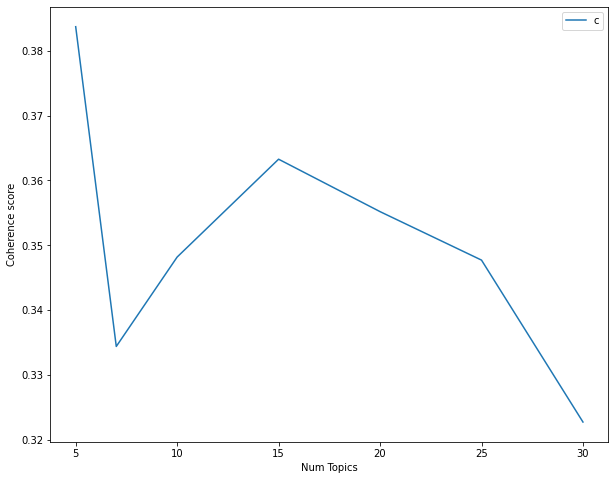

In [88]:
import matplotlib.pyplot as plt

y_res = model_results['Coherence']
x = [5,7,10,15,20,25,30]#topics_range

fig = plt.figure(figsize=(10,8))
plt.plot(x, y_res)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("c_v"), loc='best')
plt.show()

### Topic Distribution

In [175]:
total_eng_tweets = smaller_df.shape[0]
total_eng_tweets

177121

In [206]:
topics_distribution = {}
for t in range(15):
    df_topic = smaller_df[smaller_df['topic']==t]
    num_tweets = df_topic.shape[0]
    topics_distribution[t] = num_tweets
topics_distribution

{0: 8803,
 1: 16650,
 2: 1133,
 3: 7178,
 4: 6333,
 5: 28693,
 6: 15962,
 7: 11614,
 8: 6550,
 9: 4729,
 10: 9292,
 11: 17197,
 12: 14675,
 13: 8965,
 14: 19347}

In [210]:
topics_distribution_sorted = {k: v for k, v in sorted(topics_distribution.items(), key=lambda item: item[1], reverse=True)}
topics_distribution_sorted

{5: 28693,
 14: 19347,
 11: 17197,
 1: 16650,
 6: 15962,
 12: 14675,
 7: 11614,
 10: 9292,
 13: 8965,
 0: 8803,
 3: 7178,
 8: 6550,
 4: 6333,
 9: 4729,
 2: 1133}

In [211]:
distribution = pd.DataFrame(data={'topic': list(topics_distribution_sorted.keys()), 
                                  'number of tweets': list(topics_distribution_sorted.values())})

In [216]:
list_of_topics=[
    "Biden, NATO’s intervention",
    "N/A",
    "Russian army war crimes",
    "EU, NATO, US",
    "Military, troops, weapons",
    "N/A",
    "Demanding Support for Ukraine",
    "US and Russian oil, energy sanctions",
    "Trump and Putin",
    "N/A",
    "Zelenskyy: Hero or Nazi",
    "Trump Supporters, conspiracies against Zelenskyy",
    "Refugee crisis in Ukraine",
    "Western sanctions against Russia",
    "Russian vs Ukrainian propaganda"
]

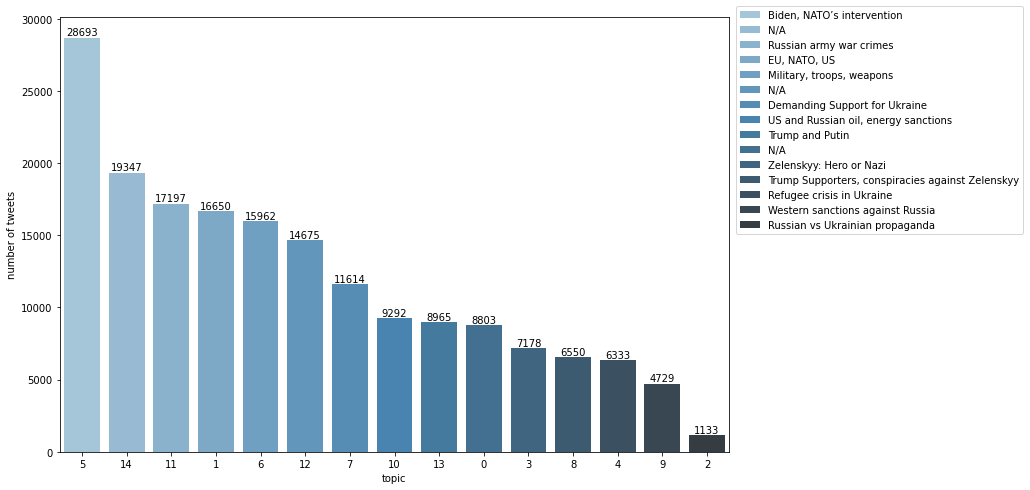

In [217]:
import seaborn as sns
fig = plt.figure(figsize=(12,8))
ax = sns.barplot(x='topic', y='number of tweets',data=distribution,palette="Blues_d", order=distribution['topic'])
ax.bar_label(ax.containers[0])
ax.legend(ax.patches, list_of_topics, loc=[1.01,0.5])